## Exploratory Data Analytics for Fraud Detection

In [2]:
!pip install feature_engine imbalanced_learn

     |████████████████████████████████| 260 kB 25.3 MB/s            
     |████████████████████████████████| 199 kB 41.5 MB/s            
     |████████████████████████████████| 205 kB 68.6 MB/s            
     |████████████████████████████████| 189 kB 57.4 MB/s            


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from feature_engine.encoding import WoEEncoder, RareLabelEncoder
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

### 0. Loading Data from the S3 Bucket

In [5]:
train = pd.read_csv('s3://trends-marketplace-data/fraud-detection/fraudTest.csv')
test = pd.read_csv('s3://trends-marketplace-data/fraud-detection/fraudTrain.csv')

### 1. Data Size

In [6]:
train.shape

(555719, 23)

In [7]:
test.shape

(1296675, 23)

In [8]:
train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


### 2. N/A Check

In [9]:
train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [10]:
test.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [11]:
train.dropna()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,555714,2020-12-31 23:59:07,30560609640617,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,...,40.4931,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0
555715,555715,2020-12-31 23:59:09,3556613125071656,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,...,29.0393,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0
555716,555716,2020-12-31 23:59:15,6011724471098086,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,...,46.1966,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0
555717,555717,2020-12-31 23:59:24,4079773899158,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,...,44.6255,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0


### 3. Train Test Data Checks

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [13]:
#check for balance
train.groupby('is_fraud')['is_fraud'].count()
#the data is very imbalance

is_fraud
0    553574
1      2145
Name: is_fraud, dtype: int64

In [14]:
train['trans_date_trans_time']=pd.to_datetime(train['trans_date_trans_time'])

train['trans_year'] = train['trans_date_trans_time'].dt.year
train['trans_month'] = train['trans_date_trans_time'].dt.month
train['trans_day'] = train['trans_date_trans_time'].dt.day
train['trans_hour'] = train['trans_date_trans_time'].dt.hour
train.shape

(555719, 27)

In [15]:
test['trans_date_trans_time']=pd.to_datetime(test['trans_date_trans_time'])

test['trans_year'] = test['trans_date_trans_time'].dt.year
test['trans_month'] = test['trans_date_trans_time'].dt.month
test['trans_day'] = test['trans_date_trans_time'].dt.day
test['trans_hour'] = test['trans_date_trans_time'].dt.hour
test.shape

(1296675, 27)

### 4. Removing the Unnamed Column

In [16]:
train.drop("Unnamed: 0",axis=1,inplace=True)

In [17]:
test.drop("Unnamed: 0",axis=1,inplace=True)

In [18]:
train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_day,trans_hour
0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,Columbia,...,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,2020,6,21,12
1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,Altonah,...,1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,2020,6,21,12
2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,Bellmore,...,1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,2020,6,21,12
3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,Titusville,...,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,2020,6,21,12
4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,Falmouth,...,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,2020,6,21,12


### 5. Categorical data transform

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  int64         
 2   merchant               555719 non-null  object        
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   first                  555719 non-null  object        
 6   last                   555719 non-null  object        
 7   gender                 555719 non-null  object        
 8   street                 555719 non-null  object        
 9   city                   555719 non-null  object        
 10  state                  555719 non-null  object        
 11  zip                    555719 non-null  int64         
 12  lat                    555719 non-null  floa

In [20]:
# merchant
train['merchant'].unique()

array(['fraud_Kirlin and Sons', 'fraud_Sporer-Keebler',
       'fraud_Swaniawski, Nitzsche and Welch', 'fraud_Haley Group',
       'fraud_Johnston-Casper', 'fraud_Daugherty LLC',
       'fraud_Romaguera Ltd', 'fraud_Reichel LLC',
       'fraud_Goyette, Howell and Collier', 'fraud_Kilback Group',
       'fraud_Feil, Hilpert and Koss', 'fraud_Gottlieb Group',
       'fraud_Connelly-Carter', 'fraud_Bechtelar-Rippin',
       'fraud_Lubowitz-Walter', 'fraud_Welch, Rath and Koepp',
       'fraud_Hickle Group', 'fraud_Lang, Towne and Schuppe',
       'fraud_Morissette LLC', 'fraud_Prosacco LLC',
       'fraud_Corwin-Romaguera', 'fraud_Tillman LLC',
       'fraud_Veum-Koelpin', 'fraud_Watsica, Haag and Considine',
       'fraud_Leannon-Ward', 'fraud_Hintz, Bauch and Smith',
       'fraud_Labadie LLC', 'fraud_Eichmann, Hayes and Treutel',
       'fraud_Leffler-Goldner', 'fraud_Kautzer and Sons',
       'fraud_Ernser-Feest', 'fraud_Zemlak, Tillman and Cremin',
       'fraud_Nienow PLC', 'fraud_L

In [21]:
train["category"].unique()

array(['personal_care', 'health_fitness', 'misc_pos', 'travel',
       'kids_pets', 'shopping_pos', 'food_dining', 'home',
       'entertainment', 'shopping_net', 'misc_net', 'grocery_pos',
       'gas_transport', 'grocery_net'], dtype=object)

In [22]:
train["first"].head()

0      Jeff
1    Joanne
2    Ashley
3     Brian
4    Nathan
Name: first, dtype: object

In [23]:
train['last'].head()

0     Elliott
1    Williams
2       Lopez
3    Williams
4      Massey
Name: last, dtype: object

In [24]:
#first and last just names, so drop it
train = train.drop(['first', 'last','merchant'], axis=1)
train.shape

(555719, 23)

In [25]:
test = test.drop(['first', 'last','merchant'], axis=1)
test.shape

(1296675, 23)

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  555719 non-null  datetime64[ns]
 1   cc_num                 555719 non-null  int64         
 2   category               555719 non-null  object        
 3   amt                    555719 non-null  float64       
 4   gender                 555719 non-null  object        
 5   street                 555719 non-null  object        
 6   city                   555719 non-null  object        
 7   state                  555719 non-null  object        
 8   zip                    555719 non-null  int64         
 9   lat                    555719 non-null  float64       
 10  long                   555719 non-null  float64       
 11  city_pop               555719 non-null  int64         
 12  job                    555719 non-null  obje

In [27]:
#change the gender into dummy variables
df_gender = pd.get_dummies(train['gender'])
 
# Binary Data is Concatenated into Dataframe
train = pd.concat((df_gender, train), axis=1)
 
# Gendercolumn is dropped
train2 = train.drop(["gender"], axis=1)
 
# We want Male =0 and Female =1 So we drop Male column here
train2 = train2.drop(["M"], axis=1)

In [28]:
#change the gender into dummy variables
test_gender = pd.get_dummies(test['gender'])
 
# Binary Data is Concatenated into Dataframe
test = pd.concat((test_gender, test), axis=1)
 
# Gendercolumn is dropped
test2 = test.drop(["gender"], axis=1)
 
# We want Male =0 and Female =1 So we drop Male column here
test2 = test2.drop(["M"], axis=1)

In [29]:
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   F                      1296675 non-null  uint8         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   street                 1296675 non-null  object        
 6   city                   1296675 non-null  object        
 7   state                  1296675 non-null  object        
 8   zip                    1296675 non-null  int64         
 9   lat                    1296675 non-null  float64       
 10  long                   1296675 non-null  float64       
 11  city_pop               1296675 non-null  int64         
 12  job                    12966

### 6. zip code has the same function as city, street, state

In [30]:
#zip code has the same function as city, street, state
train3 = train2.drop(['street', 'city','state','trans_num'], axis=1)
train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   F                      555719 non-null  uint8         
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   cc_num                 555719 non-null  int64         
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   zip                    555719 non-null  int64         
 6   lat                    555719 non-null  float64       
 7   long                   555719 non-null  float64       
 8   city_pop               555719 non-null  int64         
 9   job                    555719 non-null  object        
 10  dob                    555719 non-null  object        
 11  unix_time              555719 non-null  int64         
 12  merch_lat              555719 non-null  floa

In [31]:

test3 = test2.drop(['street', 'city','state','trans_num'], axis=1)
test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   F                      1296675 non-null  uint8         
 1   trans_date_trans_time  1296675 non-null  datetime64[ns]
 2   cc_num                 1296675 non-null  int64         
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   zip                    1296675 non-null  int64         
 6   lat                    1296675 non-null  float64       
 7   long                   1296675 non-null  float64       
 8   city_pop               1296675 non-null  int64         
 9   job                    1296675 non-null  object        
 10  dob                    1296675 non-null  object        
 11  unix_time              1296675 non-null  int64         
 12  merch_lat              12966

### 7. Converting dob

In [32]:
train3['dob']=pd.to_datetime(train3['dob'])
train3['dob'].head()

0   1968-03-19
1   1990-01-17
2   1970-10-21
3   1987-07-25
4   1955-07-06
Name: dob, dtype: datetime64[ns]

In [33]:
#converst dob
test3['dob']=pd.to_datetime(test3['dob'])
test3['dob'].head()

0   1988-03-09
1   1978-06-21
2   1962-01-19
3   1967-01-12
4   1986-03-28
Name: dob, dtype: datetime64[ns]

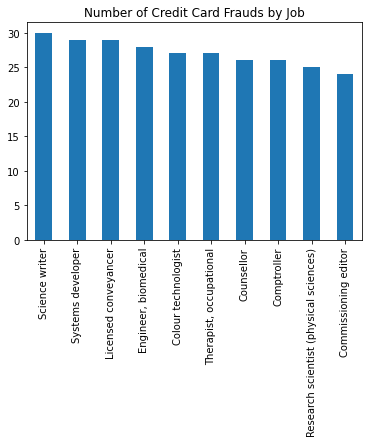

In [34]:
train3[train3['is_fraud']==1]["job"].value_counts(sort=True,ascending=False).head(10).plot(kind="bar")
plt.title("Number of Credit Card Frauds by Job")
plt.show()

In [35]:
train3['job'].unique()

array(['Mechanical engineer', 'Sales professional, IT',
       'Librarian, public', 'Set designer', 'Furniture designer',
       'Psychotherapist', 'Therapist, occupational',
       'Development worker, international aid', 'Advice worker',
       'Barrister', 'Pensions consultant', 'Freight forwarder',
       'Paramedic', 'Building surveyor', 'Materials engineer',
       'Commercial horticulturist', 'Town planner',
       'Radiographer, therapeutic', 'Surveyor, rural practice',
       'Energy manager', 'Prison officer',
       'Museum/gallery exhibitions officer', 'Media planner',
       'Seismic interpreter', 'Learning disability nurse',
       'Buyer, industrial', 'Scientific laboratory technician',
       'Counselling psychologist', 'Scientist, biomedical',
       'Audiological scientist', 'Stage manager',
       'Leisure centre manager', 'Community pharmacist', 'Risk analyst',
       'Clinical research associate', 'Librarian, academic',
       'Editor, magazine features', 'Ceramics

### 8. Engineering New Feature: age

In [36]:
train3['age'] = np.rint((pd.to_datetime('now') - train3['dob']) / np.timedelta64(1, 'Y'))

In [37]:
#construct new feature: age
test3['age'] = np.rint((pd.to_datetime('now') - test3['dob']) / np.timedelta64(1, 'Y'))

In [38]:
train3['age'].head()

0    54.0
1    32.0
2    52.0
3    35.0
4    67.0
Name: age, dtype: float64

In [39]:
train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   F                      555719 non-null  uint8         
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   cc_num                 555719 non-null  int64         
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   zip                    555719 non-null  int64         
 6   lat                    555719 non-null  float64       
 7   long                   555719 non-null  float64       
 8   city_pop               555719 non-null  int64         
 9   job                    555719 non-null  object        
 10  dob                    555719 non-null  datetime64[ns]
 11  unix_time              555719 non-null  int64         
 12  merch_lat              555719 non-null  floa

In [40]:
y = train3['is_fraud']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [41]:
X = train3.drop(['is_fraud'], axis=1)
X.head()

,F,trans_date_trans_time,cc_num,category,amt,zip,lat,long,city_pop,job,dob,unix_time,merch_lat,merch_long,trans_year,trans_month,trans_day,trans_hour,age
0,0,2020-06-21 12:14:25,2291163933867244,personal_care,2.86,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,1371816865,33.986391,-81.200714,2020,6,21,12,54.0
1,1,2020-06-21 12:14:33,3573030041201292,personal_care,29.84,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,1371816873,39.450498,-109.960431,2020,6,21,12,32.0
2,1,2020-06-21 12:14:53,3598215285024754,health_fitness,41.28,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,1371816893,40.495810,-74.196111,2020,6,21,12,52.0
3,0,2020-06-21 12:15:15,3591919803438423,misc_pos,60.05,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,1371816915,28.812398,-80.883061,2020,6,21,12,35.0
4,0,2020-06-21 12:15:17,3526826139003047,travel,3.19,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,1371816917,44.959148,-85.884734,2020,6,21,12,67.0


In [42]:
X.shape

(555719, 19)

In [48]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   F                      555719 non-null  uint8         
 1   trans_date_trans_time  555719 non-null  datetime64[ns]
 2   cc_num                 555719 non-null  int64         
 3   category               555719 non-null  object        
 4   amt                    555719 non-null  float64       
 5   zip                    555719 non-null  int64         
 6   lat                    555719 non-null  float64       
 7   long                   555719 non-null  float64       
 8   city_pop               555719 non-null  int64         
 9   job                    555719 non-null  object        
 10  dob                    555719 non-null  datetime64[ns]
 11  unix_time              555719 non-null  int64         
 12  merch_lat              555719 non-null  floa

In [49]:
from sklearn.preprocessing import OrdinalEncoder

cols = ['category', 'job']

enc = OrdinalEncoder()
X[cols] = enc.fit_transform(X[cols])

In [54]:
X = X.drop(['trans_date_trans_time', 'dob'], axis = 1)

### 9. Saving Data to S3 Bucket

In [55]:
X.to_csv("s3://trends-marketplace-data/fraud-detection/train2.csv", header = False, index = False)